In [37]:
import os
from os.path import join
import numpy as np
import json
import pickle
from transformers import BertTokenizer
from PIL import Image, ImageOps
import scipy.io
#import cv2
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [38]:
# Latex font
#plt.rc('text', usetex=False)
#plt.rc('font', family='serif')
plt.rcParams["font.family"] = "Times New Roman"

#matplotlib.use('PS')

In [ ]:
amt_data_dir = "/home/zdai/repos/EgoTransformer/Data/amt_data/"
ana_file = join('Data', 'deepdiary_data', 'lifelog', 'dataset.json')
vocab_file = join('Data', 'data', 'vocabulary.p')

# Export ONNX engine

In [39]:
import torch
import torch.onnx
import onnx

from transformers import BertTokenizer, ViTFeatureExtractor
from configuration import Config, ConfigEgo
from Eval import predict_qualitative
from models import caption

config = Config()
model, _ = caption.build_model(config)

In [74]:
checkpoint_path = join('EgoFormer', 'Baseline2-best_epoch32_loss10.pth')

checkpoint_tmp = torch.load(checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint_tmp['model'])

model.eval()
model.cpu()

Caption(
  (backbone): Joiner(
    (0): Backbone(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d()
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d()
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d()
            (relu): ReLU(inplace=True)
            (downsample): Sequential(
              (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): FrozenBatchNorm2d()
            )
 

In [75]:
def create_caption_and_mask(start_t, max_length):
    caption_template = torch.zeros((1, max_length), dtype=torch.long).cpu()  #dtype=torch.long
    mask_template = torch.ones((1, max_length), dtype=torch.bool).cpu()  #dtype=torch.bool

    caption_template[:, 0] = start_t
    mask_template[:, 0] = False

    return caption_template, mask_template

In [76]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower=True, local_files_only=False)
start_token = tokenizer.convert_tokens_to_ids(tokenizer._cls_token)

cap, cap_mask = create_caption_and_mask(start_token, config.max_position_embeddings)

In [77]:
# dummy feature extractor input
BATCH_SIZE = 1

# Baseline doesn't need feature extraction
#feats = torch.randn(BATCH_SIZE, 3, 224, 224)

In [78]:
# image input
imgs = torch.randn(BATCH_SIZE, 3, 224, 299, requires_grad=True, device='cpu')

In [79]:
imgs.shape

torch.Size([1, 3, 224, 299])

In [92]:
print(cap.shape, cap_mask.shape)

torch.Size([1, 128]) torch.Size([1, 128])


In [93]:
dummy_input = (imgs, cap, cap_mask)

model_name = "EgoFormer6.onnx"

In [96]:
# Export the model
torch.onnx.export(model,               # model being run
                  dummy_input,                         # model input (or a tuple for multiple inputs)
                  model_name,   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=12,          # the ONNX version to export the model to
                  do_constant_folding=False,  # whether to execute constant folding for optimization
                  input_names = ['image', 'cap', 'cap_mask'],   # the model's input names
                  output_names = ['seq_vocab'], # the model's output names
                  dynamic_axes={'image' : {0 : 'batch_size', 1 : 'channel', 2 : 'h', 3 : 'w'},
                                'cap' : {0 : 'batch_size', 1 : 'seq'},
                                'cap_mask' : {0 : 'batch_size', 1 : 'seq'},
                                'seq_vocab' : {0 : 'batch_size', 1 : 'seq', 2 : 'vocab'}},
                  verbose=False)


In [97]:
# ONNX checker
onnx_model = onnx.load(model_name)
try:
    onnx.checker.check_model(onnx_model)
except onnx.checker.ValidationError as e:
    print('The model is invalid: %s' % e)
else:
    print('The model is valid!')

The model is valid!


## Deepdiary Samples

In [5]:
amt_data_dir = "/Users/zhuangzhuangdai/repos/EgoTransformer/images/amt_data"
ana_file = join(amt_data_dir, 'amt_list.txt')
#vocab_file = join('Data', 'data', 'vocabulary.p')

In [ ]:
with open(ana_file, "r") as file:
    ana = json.load(file)

In [ ]:
ana['images'][0]

In [ ]:
img_305 = []
imgids = []

for img_name in os.listdir(amt_data_dir):
    for img_dict in ana['images']:
        if img_name == img_dict['filename']:
            img_305.append(img_dict)
            imgids.append(img_dict['imgid'])
            
print(len(imgids), len(img_305))

### Use 'amt_list.txt' directly

In [7]:
with open(ana_file, "r") as file:
    pairs_str = file.read()
    pairs = pairs_str.split('\n')[1:]
len(pairs)

1828

In [ ]:
img_names = {}

for pair in pairs:
    img_name = pair.split(' ')[0]
    sent_ana = pair.split('.jpg ')[-1]
    
    if img_name not in img_names:
        img_names[img_name] = [sent_ana]
    else:
        img_names[img_name].append(sent_ana)
        
len(img_names.items())

In [ ]:
my_idx = 50
for idx, (key, val) in enumerate(img_names.items()):
    if idx == my_idx:
        img_name0, cap_lst0 = key, val
        break

image0 = Image.open(join(amt_data_dir, img_name0))
# Transpose with respect to EXIF data
image0 = ImageOps.exif_transpose(image0)
w, h = image0.size
print("PIL Image width: {}, height: {}".format(w, h))

plt.imshow(image0)
plt.show()
print(cap_lst0)

In [8]:
def get_deepdiary(index, ann_filename):
    with open(ann_filename, "r") as file:
        pairs_str = file.read()
        pairs = pairs_str.split('\n')[1:]
    
    img_names = {}

    for pair in pairs:
        img_name = pair.split(' ')[0]
        sent_ana = pair.split('.jpg ')[-1]

        if img_name not in img_names:
            img_names[img_name] = [sent_ana]
        else:
            img_names[img_name].append(sent_ana)
    
    for idx, (key, val) in enumerate(img_names.items()):
        if idx == index:
            img_name0, cap_lst0 = key, val
            break

    image0 = Image.open(join(amt_data_dir, img_name0))
    # Transpose with respect to EXIF data
    image0 = ImageOps.exif_transpose(image0)
    w, h = image0.size
    print("PIL Image width: {}, height: {}".format(w, h))

    plt.imshow(image0)
    plt.show()
    print(cap_lst0)
    return image0, cap_lst0, img_name0

PIL Image width: 640, height: 480


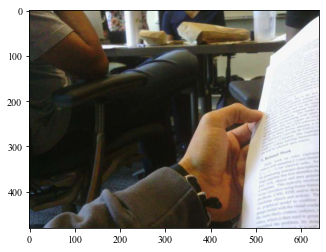

['I am reading a paper.', 'A person is sitting while reading a paper.', 'A person is sitting with other people.']


In [9]:
tuples = get_deepdiary(203, ana_file)

In [10]:
tuples

(<PIL.Image.Image image mode=RGB size=640x480>,
 ['I am reading a paper.',
  'A person is sitting while reading a paper.',
  'A person is sitting with other people.'],
 '725f30202f8b44859887c15e09ad3aa6.jpg')

# EgoCap

In [4]:
egocap_dir = '/Users/zhuangzhuangdai/repos/EgoCapSurvey/doc'
egocap_filename = 'analyzed_annatations.json'

In [22]:
with open(join(egocap_dir, egocap_filename), 'r') as f:
    ana = json.load(f)

In [23]:
len(ana)

2079

In [24]:
# Reference labels
ego4d_dir = '/Users/zhuangzhuangdai/ego4d_data'
with open(join(ego4d_dir, 'ego4d.json')) as f:
    ref_ego4d = json.load(f)
    
coco_dir = '/Users/zhuangzhuangdai/repos/EgoTransformer/images/annotations'
with open(join(coco_dir, 'captions_val2017.json')) as f:
    ref_coco = json.load(f)
    
msvd_dir = '/Users/zhuangzhuangdai/repos/MSVD/'
with open(join(msvd_dir, 'AllVideoDescriptions.txt')) as f:
    ref_msvd = f.readlines()
    
msrvtt_dir = '/Users/zhuangzhuangdai/repos/MSRVTT/train_val_annotation'
with open(join(msrvtt_dir, 'train_val_videodatainfo.json')) as f:
    ref_msrvtt = json.load(f)
    
# MSRVTT Category
with open(join(msrvtt_dir, 'category.txt')) as f:
    ref_msrvtt_cat = f.readlines()

In [29]:
### Add reference labels from original {COCO, Ego4D, MSVD, MSRVTT} datasets ###
def update_ann_reference(ann, ref, ref_co, ref_vd=None, ref_vtt=None, ref_vtt_cat=None):
    
    for idx, (key, val) in enumerate(ann.items()):
        filename = None
        try:
            # For image name parsing
            key_lst = key.split('.')
            #print(key_lst[0], len(key_lst))
            
            if len(key_lst) == 3 and key_lst[1] == "avi00001":
                # MSVD
                filename = key_lst[0]
                if ref_vd is not None:
                    for video_item in ref_vd:
                        if video_item.startswith(filename):
                            labels = video_item[len(filename) + 1:-1]
                            ann[key]['reference'] = {
                                'origin': 'MSVD',
                                'labels': [labels]
                            }
                            break
            
            elif len(key_lst) == 3 and key_lst[1] == "mp400001":
                # MSRVTT
                if ref_vtt is not None:
                    for video_item in ref_vtt['videos']:
                        filename = key_lst[0]
                        if video_item['video_id'] == filename:
                            cat_num = int(video_item['category'])
                            labels = ref_vtt_cat[cat_num].split('\t')[0]
                            ann[key]['reference'] = {
                                'origin': 'MSRVTT',
                                'labels': [labels]
                            }
            
            else:
                key_lst = key.split('.')[0].split('_')
                if len(key_lst) == 1:
                    # COCO
                    filename = key_lst[0]
                    cap_lst = []
                    for video_item in ref_co['annotations']:
                        if str(video_item['image_id']).zfill(12) == filename:
                            cap_lst.append(video_item['caption'])

                    ann[key]['reference'] = {
                                'origin': 'coco_val2017',
                                'labels': cap_lst
                            }
                
                elif len(key_lst) == 2:
                    # Ego4D
                    filename = key_lst[0]

                    for video_item in ref['videos']:
                        if video_item['video_uid'] == filename:
                            labels = video_item['scenarios']
                            ann[key]['reference'] = {
                                'origin': 'Ego4D',
                                'labels': labels
                            }
                            break
                        else:
                            ann[key]['reference'] = {
                                'origin': 'Ego4D',
                                'labels': []
                            }
                    
                else:
                    raise KeyError("Source image name invalid/non-exist!")
            
        except:
            raise TypeError("Not an image with reference!")
            
    return ann

In [30]:
new_ana = update_ann_reference(ana, ref_ego4d, ref_coco, ref_msvd, ref_msrvtt, ref_msrvtt_cat)

In [31]:
# Export "analyzed_annatations_ref"
with open(join(egocap_dir, 'EgoCap_annatations_ref.json'), 'w', encoding='utf-8') as f:
    json.dump(new_ana, f, ensure_ascii=False, indent=4)

### EgoCap Analysis

In [3]:
egocap_dir = '/Users/zhuangzhuangdai/repos/EgoCapSurvey/doc'

In [4]:
# Load "analyzed_annatations_ref"
with open(join(egocap_dir, 'EgoCap_annatations_ref.json'), 'r') as f:
    ana = json.load(f)

In [5]:
import nltk
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

def tagger(string):
    PEOPLE_ONLY, OBJ_ONLY, PEOPLE_OBJ, DOING = False, False, False, False
    text = nltk.word_tokenize(string)
    taggers = nltk.pos_tag(text)
    
    tags = [item[1] for item in taggers]
    if ('PRP' in tags or 'PRP$' in tags or 'NNP' in tags or 'NNPS' in tags) and ('NN' not in tags and 'NNS' not in tags):
        PEOPLE_ONLY = True
            
    if ('PRP' not in tags or 'PRP$' not in tags or 'NNP' not in tags or 'NNPS' not in tags) and ('NN' in tags and 'NNS' in tags):
        OBJ_ONLY = True
        
    if ('PRP' in tags or 'PRP$' in tags or 'NNP' in tags or 'NNPS' in tags) and ('NN' in tags and 'NNS' in tags):
        PEOPLE_OBJ = True
            
    if 'VB' in tags or 'VBG' in tags:
        DOING = True
        
    return PEOPLE_ONLY, OBJ_ONLY, PEOPLE_OBJ, DOING

In [6]:
people_only, obj_only, people_obj, doing = 0,0,0,0
people_others = 0

for idx, (key, val) in enumerate(ana.items()):
    #print(key)
    sent = val['reference']['labels']
    
    if len(sent) > 0:
        tuples = tagger(sent[0])
        if tuples[0]:
            people_only += 1
            
        if tuples[1]:
            obj_only += 1
        if tuples[2]:
            people_obj += 1
        if tuples[3]:
            doing += 1
            for sentence in sent:
                if 'see' in sentence or 'watch' in sentence or 'look' in sentence or 'man' in sentence or 'lady' in sentence or 'girl' in sentence or 'boy' in sentence or 'baby' in sentence:
                    people_others += 1

In [7]:
people_only, obj_only, people_obj, doing, people_others

(45, 388, 160, 1142, 303)

In [8]:
total = 2079

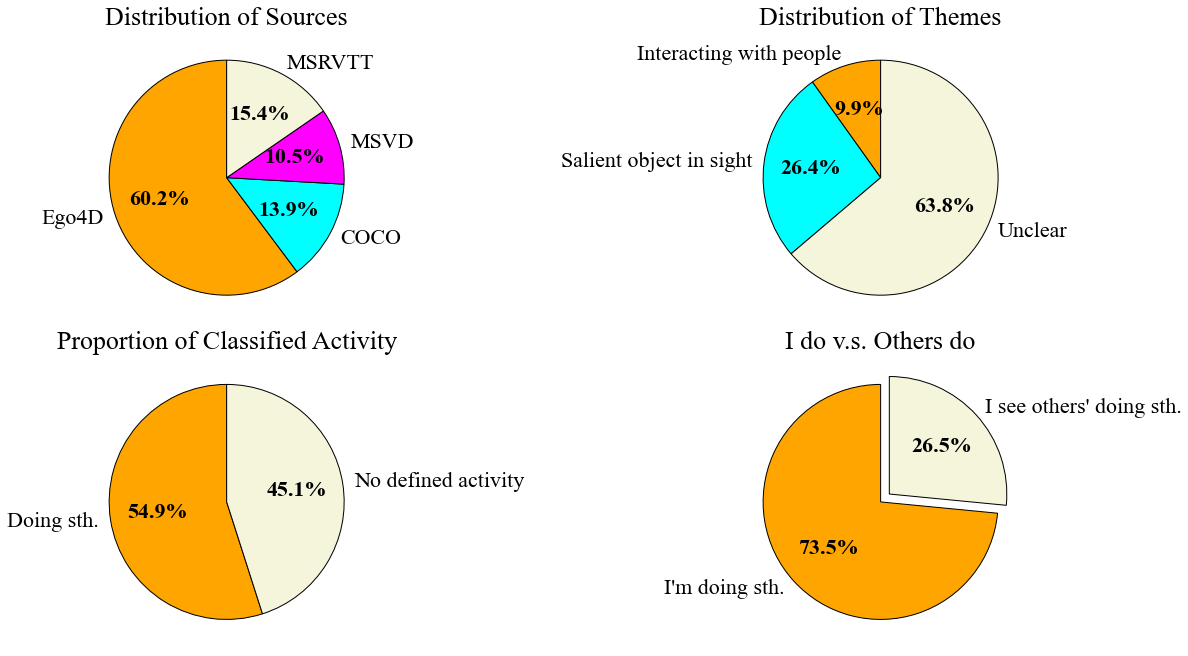

In [11]:
names0 = ['Ego4D', 'COCO', 'MSVD', 'MSRVTT']
data0 = [1252, 289, 218, 320]
explode0 = (0.0, 0.0, 0.0, 0.0)
colors0 = ( "orange", "cyan", "magenta", "beige")

# Creating dataset
names = ['Interacting with people', 'Salient object in sight', 'Unclear']
data = [people_only + people_obj, obj_only + people_obj, total - people_only - obj_only - 2*people_obj]

# Creating explode data
explode = (0.0, 0.0, 0.0)

# Creating color parameters
colors = ( "orange", "cyan", "beige")

# Wedge properties
wp = { 'linewidth' : 1., 'edgecolor' : "black" }


names2 = ["Doing sth.", "No defined activity"]
data2 = [doing, total-doing]
explode2 = (0.0, 0.0)
colors2 = ( "orange", "beige" )

names4 = ["I'm doing sth.", "I see others' doing sth."]
data4 = [doing - people_others, people_others]
explode4 = (0.0, 0.1)
colors4 = ( "orange", "beige" )


# Creating autocpt arguments
def func(pct, allvalues):
	absolute = int(pct / 100.*np.sum(allvalues))
	return "{:.1f}%".format(pct, absolute)

# Creating plot
fig, ax = plt.subplots(2, 2, figsize =(18, 9), constrained_layout=True)

wedges, texts, autotexts = ax[0,0].pie(data0,
								autopct = lambda pct: func(pct, data0),
								explode = explode0,
								labels = names0,
								shadow = False,
								colors = colors0,
								startangle = 90,
								wedgeprops = wp,
								textprops = dict(color ="black", fontsize=22))
ax[0,0].set_title("Distribution of Sources", fontsize=26)
plt.setp(autotexts, size = 22, weight ="bold")
'''
ax[0].set_xticks(range(len(data0)), names0, fontsize=18)
ax[0].set_xlabel('')
ax[0].set_ylabel('Number of Images', fontsize=18)
ax[0].set_title("Distribution of Sources", fontsize=24)
ax[0].bar(range(len(data0)), data0) 
'''

wedges, texts, autotexts = ax[0,1].pie(data,
								autopct = lambda pct: func(pct, data),
								explode = explode,
								labels = names,
								shadow = False,
								colors = colors,
								startangle = 90,
								wedgeprops = wp,
								textprops = dict(color ="black", fontsize=22))
ax[0,1].set_title("Distribution of Themes", fontsize=26)
plt.setp(autotexts, size = 22, weight ="bold")

wedges, texts, autotexts = ax[1,0].pie(data2,
								autopct = lambda pct: func(pct, data2),
								explode = explode2,
								labels = names2,
								shadow = False,
								colors = colors2,
								startangle = 90,
								wedgeprops = wp,
								textprops = dict(color ="black", fontsize=22))
ax[1,0].set_title("Proportion of Classified Activity", fontsize=26)
plt.setp(autotexts, size = 22, weight ="bold")

wedges, texts, autotexts = ax[1,1].pie(data4,
								autopct = lambda pct: func(pct, data4),
								explode = explode4,
								labels = names4,
								shadow = False,
								colors = colors4,
								startangle = 90,
								wedgeprops = wp,
								textprops = dict(color ="black", fontsize=22))
ax[1,1].set_title("I do v.s. Others do", fontsize=26)
plt.setp(autotexts, size = 22, weight ="bold")

# Adding legend
#ax.legend(wedges, cars, title ="Cars", loc ="center left", bbox_to_anchor =(1, 0, 0.5, 1))


# show plot
fig.savefig(join('images','pdf',"pie_egocap3.pdf"), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

# MODEL EVAL

In [4]:
from configuration import Config, ConfigEgo
from Eval import predict_qualitative
from pycocoevalcap.bleu.bleu import Bleu, BleuScorer
from pycocoevalcap.meteor.meteor import Meteor, METEOR_JAR
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider, CiderScorer
from pycocoevalcap.spice.spice import Spice, SPICE_JAR

def calc_scores(ref, hypo):
    """
    ref, dictionary of reference sentences (id, sentence)
    hypo, dictionary of hypothesis sentences (id, sentence)
    score, dictionary of scores
    """
    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        #(Meteor(), "METEOR"),
        (Rouge(), "ROUGE_L"),
        (Cider(), "CIDEr"),
        #(Spice(), "SPICE")
    ]
    final_scores = {}
    for scorer, method in scorers:
        score, scores = scorer.compute_score(ref, hypo)
        if type(score) == list:
            for m, s in zip(method, score):
                final_scores[m] = s
        else:
            final_scores[method] = score
    return final_scores

## Eval on EgoCap

In [5]:
egocap_dir = '/Users/zhuangzhuangdai/repos/EgoCapSurvey'
egocap_filename = 'EgoCap_annatations_ref.json'

with open(join(egocap_dir, 'doc', egocap_filename), 'r') as f:
    ana = json.load(f)

In [6]:
len(ana)

2079

In [7]:
ana[next(iter(ana))]

{'SplitIndex': 18,
 'captions': ['I am walking outside.',
  'I see a woman in a park.',
  'I am walking in the park.',
  'I am in a park on a sunny day.',
  'i am in a park.'],
 'tags': {'where': ['outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor'],
  'what_activity': ['na', 'na', 'na', 'na', 'na'],
  'when': ['daytime', 'daytime', 'daytime', 'daytime', 'daytime'],
  'who': ['human', 'na', 'na', 'na', 'object']},
 'reported': 'False',
 'cap_similarity': {'Bleu_1': 0.5841005870115037,
  'Bleu_2': 0.5506953146048907,
  'Bleu_3': 0.4906137498333178,
  'Bleu_4': 9.792901389423636e-05,
  'ROUGE_L': 0.5791139240506329,
  'CIDEr': 0.0},
 'tag_stats': {'where': {'majority': 'outdoor',
   'percentage': 1.0,
   'total_options': 1},
  'what_activity': {'majority': 'na', 'percentage': 1.0, 'total_options': 1},
  'when': {'majority': 'daytime', 'percentage': 1.0, 'total_options': 1},
  'who': {'majority': 'na', 'percentage': 0.6, 'total_options': 3}},
 'REPORTED': 'False',
 'reference': {'origin

In [8]:
config_t = Config()
config_ego = ConfigEgo()

baseline = 'EgoFormer/Baseline2-best_epoch32_loss10.pth'  #'13 - finetune-epoch29_loss15.pth'
egotrans = 'EgoFormer/EgoFormer3-equalloss-best_epoch33_loss10.pth'

trans_concat = 'EgoFormer/EgoFormerConcat-smallLR-best_epoch19_loss10.pth'
trans_gatedinfo = 'EgoFormer/GatedViT_smallLR-best_epoch19_loss10.pth'

egotrans_prefuse = 'EgoFormer/EgoFormer-PreFuse3-best_epoch33_loss10.pth'
egotrans_contextembed = '16 - contextembed -finetuneEgoTrans-best_epoch50_loss25.pth'
egotrans_contextfuse = 'finetuneEgoTrans-best_epoch17_loss10.pth'
egotrans_encodernograd = 'EgoFormer/EgoFormer3-backboneViTnograd-best_epoch32_loss10.pth'
egotrans_backbonegrad = 'EgoFormer/EgoFormer3-backboneViTwithgrad-best_epoch30_loss10.pth'
egotrans_blind = 'EgoFormer/EgoFormer-BlindContext-best_epoch21_loss10.pth'
# egotrans_raw is obtained through loading ImageNet pretrained ViT params directly

In [9]:
# Prompt image
sample_name = 'fjDvKHkmxs0_119_126.avi00001.jpg'

split_idx = str(ana[sample_name]['SplitIndex']).zfill(2)
sample_path = join(egocap_dir, 'static', 'Split' + split_idx, sample_name)
tags = (ana[sample_name]['tag_stats']['where']['majority'], ana[sample_name]['tag_stats']['when']['majority'])

In [10]:
base_dict = predict_qualitative(config_t, sample_path, tags=None, checkpoint_path=baseline)

Loading Checkpoint...
Current checkpoint epoch = 32
Initializing Device: cpu
Loading pretrained Tokenizer takes: 3.33s
Total Vocal =  30522
Start Token: [CLS]; End Token: [SEP]; Padding: [PAD]
PIL Image width: 480, height: 360
Sample shape:  torch.Size([1, 3, 224, 299])

I am in a car.



In [79]:
cap_dict = predict_qualitative(config_ego, sample_path, tags=tags, checkpoint_path=egotrans)

Loading Checkpoint...
Current checkpoint epoch = 33
Initializing Device: cpu
Loading pretrained Tokenizer takes: 3.90s
Total Vocal =  30522
Start Token: [CLS]; End Token: [SEP]; Padding: [PAD]
PIL Image width: 480, height: 360

I am in a car.



In [80]:
gts = {sample_name: ana[sample_name]['captions']}
print(gts)

{'fjDvKHkmxs0_119_126.avi00001.jpg': ['I am on a car running on a road.', 'I am at the rear seat of a car.', 'i am in a car.', 'I am sitting in a car with a man.', 'I am watching my friend who is driving the car.']}


In [ ]:
# Quantatitive Eval
base_metrics = calc_scores(gts, base_dict)
cap_metrics = calc_scores(gts, cap_dict)
print(base_metrics, cap_metrics)

### Qualitative

In [81]:
# Load Image
image = Image.open(sample_path)
# Transpose with respect to EXIF data
image = ImageOps.exif_transpose(image)
w, h = image.size
print("PIL Image width: {}, height: {}".format(w, h))

PIL Image width: 480, height: 360


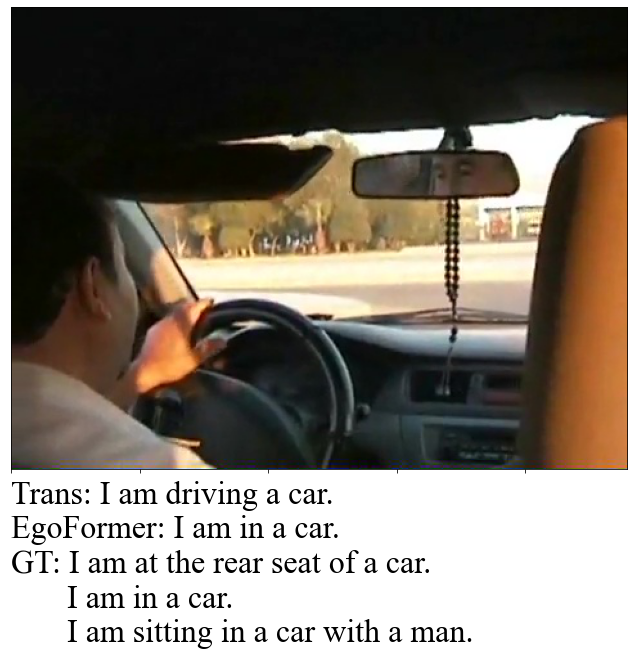

In [82]:
# Visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 9), constrained_layout=True)

ax.set_xlabel("Trans: " + base_dict[sample_name][0].capitalize() +
              '\n' + "EgoFormer: " + cap_dict[sample_name][0].capitalize() +
              '\n' + "GT: " + gts[sample_name][1].capitalize() +
              '\n' + "       " + gts[sample_name][2].capitalize() +
              '\n' + "       " + gts[sample_name][3].capitalize(),
              fontsize=32, horizontalalignment='left', x=-0.0,
              #fontdict=dict(weight='bold')
             )

plt.imshow(image)
#ax.set_yticklabels([])
ax.set_xticklabels([])
plt.gca().get_yaxis().set_visible(False)

fig.savefig(join('images', 'EgoFormer3', sample_path.split("/")[-1]), facecolor='w', bbox_inches='tight')

plt.show()

PIL Image width: 640, height: 480


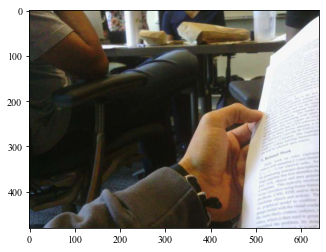

['I am reading a paper.', 'A person is sitting while reading a paper.', 'A person is sitting with other people.']


In [83]:
### Load DeepDiary samples ###
amt_data_dir = "/Users/zhuangzhuangdai/repos/EgoTransformer/images/amt_data"
diary_file = join(amt_data_dir, 'amt_list.txt')

diary_tuple = get_deepdiary(203, diary_file)  # 93, 
sample_path = join(amt_data_dir, diary_tuple[2])

In [84]:
base_dict = predict_qualitative(config_t, sample_path, tags=None, checkpoint_path=baseline)

Loading Checkpoint...
Current checkpoint epoch = 29
Initializing Device: cpu
Loading pretrained Tokenizer takes: 3.48s
Total Vocal =  30522
Start Token: [CLS]; End Token: [SEP]; Padding: [PAD]
PIL Image width: 640, height: 480

I am reading a book.



In [85]:
cap_dict = predict_qualitative(config_ego, sample_path, tags=None, checkpoint_path=egotrans)

Loading Checkpoint...
Current checkpoint epoch = 33
Initializing Device: cpu
Loading pretrained Tokenizer takes: 3.92s
Total Vocal =  30522
Start Token: [CLS]; End Token: [SEP]; Padding: [PAD]
PIL Image width: 640, height: 480

I am sitting in a room.



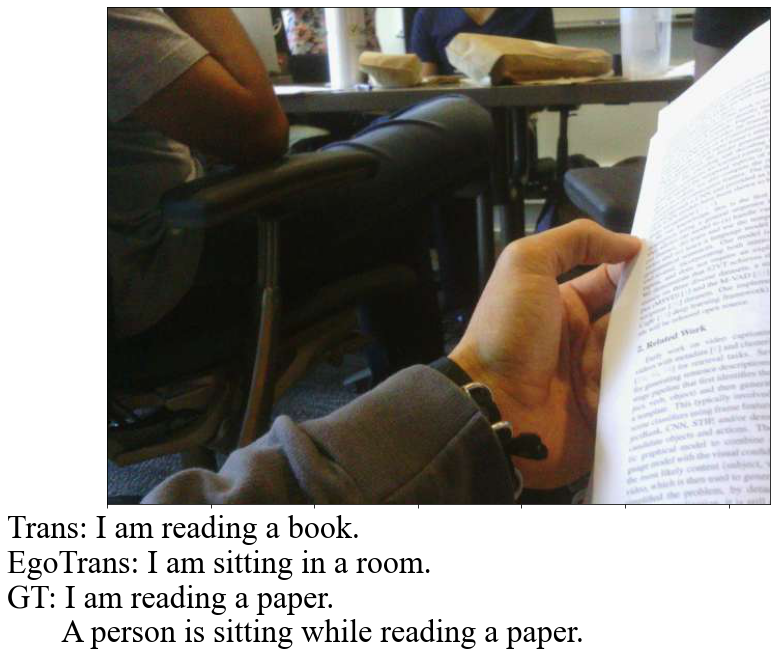

In [101]:
# Visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 9), constrained_layout=True)

ax.set_xlabel("Trans: " + base_dict[next(iter(base_dict))][0].capitalize() +
              '\n' + "EgoTrans: " + cap_dict[next(iter(cap_dict))][0].capitalize() +
              '\n' + "GT: " + diary_tuple[1][0] +
              '\n' + "       " + diary_tuple[1][1],
              #'\n' + "      " + diary_tuple[1][2],
              fontsize=32, horizontalalignment='left', x=-0.15,
              #fontdict=dict(weight='bold')
             )

plt.imshow(diary_tuple[0])
#ax.set_yticklabels([])
ax.set_xticklabels([])
plt.gca().get_yaxis().set_visible(False)

fig.savefig(join('images', 'deepdiary2', diary_tuple[2]), facecolor='w', bbox_inches='tight')

plt.show()

### Quantitative

In [11]:
eval_split = ['03', '10', '17']

config_t = Config()
config_ego = ConfigEgo()

baseline = 'EgoFormer/Baseline2-best_epoch32_loss10.pth'  #'13 - finetune-epoch29_loss15.pth'
egotrans = 'EgoFormer/EgoFormer3-equalloss-best_epoch33_loss10.pth'

trans_concat = 'EgoFormer/EgoFormerConcat-smallLR-best_epoch19_loss10.pth'
trans_gatedinfo = 'EgoFormer/GatedViT_smallLR-best_epoch19_loss10.pth'

egotrans_prefuse = 'EgoFormer/EgoFormer-PreFuse3-best_epoch33_loss10.pth'
egotrans_contextembed = '16 - contextembed -finetuneEgoTrans-best_epoch50_loss25.pth'
egotrans_contextfuse = 'finetuneEgoTrans-best_epoch17_loss10.pth'
egotrans_encodernograd = 'EgoFormer/EgoFormer3-backboneViTnograd-best_epoch32_loss10.pth'
egotrans_backbonegrad = 'EgoFormer/EgoFormer3-backboneViTwithgrad-best_epoch30_loss10.pth'
egotrans_blind = 'EgoFormer/EgoFormer-BlindContext-best_epoch21_loss10.pth'
# egotrans_raw is obtained through loading ImageNet pretrained ViT params directly


In [12]:
def Loop_quantitative_eval(config, checkpoint, annotations, split_lst, egocap_dir_path='/Users/zhuangzhuangdai/repos/EgoCapSurvey'):
    hypo = {}
    refs = {}
    sample_path_lst, tags_lst = [], []
    
    for split in split_lst:
        for idx, (key, val) in enumerate(annotations.items()):
            if int(split) == int(val['SplitIndex']):
                sample_name = key
                sample_path = join(egocap_dir_path, 'static', 'Split' + split.zfill(2), sample_name)
                
                if config.modality == 'ego':
                    tags = (val['tag_stats']['where']['majority'], val['tag_stats']['when']['majority'])
                else:
                    tags = None
                    
                sample_path_lst.append(sample_path)
                tags_lst.append(tags)
                
                ref = {sample_name: val['captions']}
                refs.update(ref)
                
    # Inference with lists of sample_path & tags
    pred_dict = predict_qualitative(config, sample_path_lst, tags_lst, checkpoint_path=checkpoint)
    hypo.update(pred_dict)
                
    metrics = calc_scores(refs, hypo)
    print(metrics)
    return hypo, refs, metrics

def quantitative_eval(config, checkpoint, annotations, split_lst, egocap_dir_path='/Users/zhuangzhuangdai/repos/EgoCapSurvey'):
    hypo = {}
    refs = {}
    for split in split_lst:
        for idx, (key, val) in enumerate(annotations.items()):
            if int(split) == int(val['SplitIndex']):
                sample_name = key
                sample_path = join(egocap_dir_path, 'static', 'Split' + split.zfill(2), sample_name)
                
                if config.modality == 'ego':
                    tags = (val['tag_stats']['where']['majority'], val['tag_stats']['when']['majority'])
                else:
                    tags = None
                
                ref = {sample_name: val['captions']}
                refs.update(ref)
                # Inference
                pred_dict = predict_qualitative(config, sample_path, tags=tags, checkpoint_path=checkpoint)
                hypo.update(pred_dict)
                
    metrics = calc_scores(refs, hypo)
    print(metrics)
    return hypo, refs, metrics

In [13]:
#%%capture
tuples0 = Loop_quantitative_eval(config_t, baseline, ana, eval_split)

Loading Checkpoint...
Current checkpoint epoch = 32
Initializing Device: cpu
Loading pretrained Tokenizer takes: 3.24s
Total Vocal =  30522
Start Token: [CLS]; End Token: [SEP]; Padding: [PAD]
PIL Image width: 480, height: 360
Sample shape:  torch.Size([1, 3, 224, 299])

I am in a kitchen.

PIL Image width: 480, height: 360
Sample shape:  torch.Size([1, 3, 224, 299])

I am using a phone.

PIL Image width: 480, height: 360
Sample shape:  torch.Size([1, 3, 224, 299])

I am in a kitchen.

PIL Image width: 480, height: 360
Sample shape:  torch.Size([1, 3, 224, 299])

I am looking out the window.

PIL Image width: 480, height: 360
Sample shape:  torch.Size([1, 3, 224, 299])

I am in a corridor.

PIL Image width: 480, height: 360
Sample shape:  torch.Size([1, 3, 224, 299])

I am talking to a group of people.

PIL Image width: 480, height: 360
Sample shape:  torch.Size([1, 3, 224, 299])

I am sitting on a sofa.

PIL Image width: 480, height: 360
Sample shape:  torch.Size([1, 3, 224, 299])

I 

KeyboardInterrupt: 

In [21]:
print("Baseline Transformer eval report: ", tuples0[2])

Baseline Transformer eval report:  {'Bleu_1': 0.6303747131606764, 'Bleu_2': 0.48373486932691445, 'Bleu_3': 0.3739451024835358, 'Bleu_4': 0.285301748458391, 'ROUGE_L': 0.5486763971747014, 'CIDEr': 0.8722750979039395}


In [113]:
%%capture
tuples2 = Loop_quantitative_eval(config_ego, egotrans, ana, eval_split)

In [114]:
print("EgoFormer eval report: ", tuples2[2])

EgoFormer eval report:  {'Bleu_1': 0.6543711311947304, 'Bleu_2': 0.5213743973283095, 'Bleu_3': 0.41709896158338367, 'Bleu_4': 0.3246145482358901, 'ROUGE_L': 0.5712747104393757, 'CIDEr': 1.0204332867933585}


In [17]:
%%capture
tuples3 = Loop_quantitative_eval(config_ego, egotrans_backbonegrad, ana, eval_split)

In [18]:
print("EgoFormer_backbonegrad eval report: ", tuples3[2])

EgoFormer_backbonegrad eval report:  {'Bleu_1': 0.6291835381919852, 'Bleu_2': 0.4960818300190133, 'Bleu_3': 0.39294722556724543, 'Bleu_4': 0.30499465888683097, 'ROUGE_L': 0.5507774057332855, 'CIDEr': 0.9430067752025725}


In [15]:
%%capture
tuples4 = Loop_quantitative_eval(config_ego, egotrans_encodernograd, ana, eval_split)

In [16]:
print("EgoFormer_encodernograd eval report: ", tuples4[2])

EgoFormer_encodernograd eval report:  {'Bleu_1': 0.6670698484745052, 'Bleu_2': 0.5340880965016057, 'Bleu_3': 0.4329743080953382, 'Bleu_4': 0.3452534963905967, 'ROUGE_L': 0.5693047420604181, 'CIDEr': 0.9786529080131159}


## Eval on COCO

In [6]:
coco_dir = '/Users/zhuangzhuangdai/repos/EgoTransformer/images'
coco_filename = 'captions_val2017.json'

with open(join(coco_dir, 'annotations', coco_filename), 'r') as f:
    annotations = json.load(f)

In [7]:
ana = annotations['annotations']

In [15]:
print(len(ana), ana[0])

25014 {'image_id': 179765, 'id': 38, 'caption': 'A black Honda motorcycle parked in front of a garage.'}


In [21]:
config_t = Config()
config_ego = ConfigEgo()

EgoCO_base = '/Users/zhuangzhuangdai/repos/EgoTransformer/checkpoint_cl.pth'
EgoCO_blind = '/Users/zhuangzhuangdai/repos/EgoTransformer/EgoCO/EgoCO_blind-best_epoch14_loss21.pth'
EgoCO_raw = None

In [12]:
# Prompt image
def _process(image_id):
    val = str(image_id).zfill(12)
    return val + '.jpg'

sample_name = _process(179765)

sample_path = join(coco_dir, 'val2017', sample_name)

In [14]:
base_dict = predict_qualitative(config_t, sample_path, tags=None, checkpoint_path=EgoCO_base)

Loading Checkpoint...
Current checkpoint epoch = 11
Initializing Device: cpu
Loading pretrained Tokenizer takes: 3.65s
Total Vocal =  30522
Start Token: [CLS]; End Token: [SEP]; Padding: [PAD]
PIL Image width: 640, height: 480

A motorcycle parked in a driveway near a house.



In [22]:
blind_dict = predict_qualitative(config_ego, sample_path, tags=None, checkpoint_path=EgoCO_blind)

Loading Checkpoint...
Current checkpoint epoch = 14
Initializing Device: cpu
Loading pretrained Tokenizer takes: 3.60s
Total Vocal =  30522
Start Token: [CLS]; End Token: [SEP]; Padding: [PAD]
PIL Image width: 640, height: 480

A motorcycle parked in a yard near a house.



### Quantitative

In [19]:
def _process(image_id):
    val = str(image_id).zfill(12)
    return val + '.jpg'

def Loop_quantitative_eval(config, checkpoint, annotations, split_lst=['val2017'], coco_dir_path='/Users/zhuangzhuangdai/repos/EgoTransformer/images'):
    hypo = {}
    refs = {}
    sample_path_lst = []
    
    # Loop through validation dir(s)
    for split in split_lst:
        for idx, cap in enumerate(annotations):
            if _process(cap['image_id']) in os.listdir(join(coco_dir_path, split)):
                sample_name = _process(cap['image_id'])
                sample_path = join(coco_dir_path, split, sample_name)
                
                # Add coco abs sample_path to list()
                sample_path_lst.append(sample_path)
                # Add coco captions (all 5)
                ref = {sample_name: cap['caption']}
                refs.update(ref)
    print("Done sorting refs, total testing samples = ", len(refs))
                
    # Inference with lists of sample_path
    pred_dict = predict_qualitative(config, sample_path_lst, tags=None, checkpoint_path=checkpoint)
    # Note: pred_dict is of dict: {'<image_name.jpg>': ["cap1.", "cap2." ...], ...}
    hypo.update(pred_dict)
    
    # Compute Metrics!
    metrics = calc_scores(refs, hypo)
    print(metrics)
    return hypo, refs, metrics

In [20]:
tuples_base = Loop_quantitative_eval(config_t, EgoCO_base, ana)

Done sorting refs, total testing samples =  4999


Using cache found in /Users/zhuangzhuangdai/.cache/torch/hub/saahiluppal_catr_master


Initializing Device: cpu
Loading pretrained Tokenizer takes: 3.47s
Total Vocal =  30522
Start Token: [CLS]; End Token: [SEP]; Padding: [PAD]
PIL Image width: 640, height: 480

A motorcycle parked in a field of grass.

PIL Image width: 640, height: 480

A motorcycle parked in a field of grass.

PIL Image width: 640, height: 393

A desk with a computer and a laptop on it.

PIL Image width: 351, height: 500


KeyboardInterrupt: 

In [ ]:
tuples_base

In [23]:
tuples_blind = Loop_quantitative_eval(config_ego, EgoCO_blind, ana)

Done sorting refs, total testing samples =  4999
Loading Checkpoint...
Current checkpoint epoch = 14
Initializing Device: cpu
Loading pretrained Tokenizer takes: 3.78s
Total Vocal =  30522
Start Token: [CLS]; End Token: [SEP]; Padding: [PAD]
PIL Image width: 640, height: 480

A motorcycle parked in a yard near a house.

PIL Image width: 640, height: 480

A motorcycle parked in a yard near a house.

PIL Image width: 640, height: 393

A room with a desk, chair, and computer.

PIL Image width: 351, height: 500


KeyboardInterrupt: 

In [ ]:
tuples_blind

In [ ]:
tuples_raw = Loop_quantitative_eval(config_ego, EgoCO_raw, ana)

In [ ]:
tuples_raw